## SILICON Demo Toolkit: Fearspeech Task

This notebook is part of the SILICON toolkit (using LLMs for text annotation) released by Xiang Cheng, Raveesh Mayya, and João Sedoc: “To Err Is Human; To Annotate, SILICON? Reducing Measurement Error in LLM Annotation.” See the arXiv preprint: [link](https://arxiv.org/abs/2412.14461).

- **Dataset provenance**: The demo dataset and annotation guidelines are based on Saha et al. (2023), “On the rise of fear speech in online social media,” Proceedings of the National Academy of Sciences 120(11): e2212270120. The annotation task is to identify fearspeech and hatespeech in social media posts. The "majority_label" column is considered as the human annotation baseline, provided by the original dataset.
- **Demo note**: Under `/outputs/`, several pre-saved files correspond to a small demonstration subset (~10 rows) to help you run the code.

### What this notebook does
- **Section 0**: Set up paths, inputs, and prompts for the fearspeech task.
- **Section 1**: Run multiple LLMs (OpenAI, Anthropic, Google) to annotate a sample of items.
- **Section 2**: Merge multiple runs into a single combined CSV.
- **Section 3**: Compute agreement (Cohen’s Kappa) between ground truth and LLM labels.
- **Section 4**: Build a regression-ready CSV and (optionally) run an R-based comparison script.
- **Section 5**: Generate a plot showing how agreement changes as we vary the confidence threshold for using a single model vs. majority vote.

If you only want to explore the analysis and plots, you can skip the inference step if you already have combined CSVs in `/outputs/Combined_Files/`. 


### Section 0 — Setup paths, inputs, and prompts

Key variables:
- **`SCRIPT_DIR`**: Absolute path to this `silicon_demo` folder.
- **`BASE_PATH`**: Base path for reading/writing demo artifacts (defaults to `SCRIPT_DIR`).
- **`OUTPUT_DIR`**: Where combined outputs are saved (defaults to `outputs/Combined_Files`).
- **`INPUT_DATA_PATH`**: Path to the demo CSV (defaults to `inputs/pnas_2023_fearspeech_sample.csv`).
- **`pattern_label`**: Regex for extracting `id` and `label` from LLM responses.
- **`task_prompts`**: Instruction and user prompts loaded from `inputs/prompt_fearspeech.json`.

If you are reusing pre-saved outputs under `silicon_demo/outputs/`, you may skip running Section 1.


In [1]:
import os
import json
import subprocess
import pandas as pd

# Resolve paths relative to this demo folder
SCRIPT_DIR = os.path.dirname(os.path.abspath("__file__")) if "__file__" in globals() else os.getcwd()
REPO_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, '..'))
BASE_PATH = os.getenv('BASE_PATH', SCRIPT_DIR)
OUTPUT_DIR = os.getenv('OUTPUT_DIR', 'outputs/Combined_Files')

# Paths and inputs
DATA_PATH = os.getenv('INPUT_DATA_PATH', os.path.join(SCRIPT_DIR, 'inputs', 'pnas_2023_fearspeech_sample.csv'))
df_task = pd.read_csv(DATA_PATH)
pattern_label = r'"id":\s*"([^"]+)"\s*,\s*"label":\s*"([^"]+)"'
with open(os.path.join(SCRIPT_DIR, 'inputs', 'prompt_fearspeech.json'), 'r', encoding='utf-8') as json_file:
    task_prompts = json.load(json_file)

print(f"Loaded sample with {len(df_task)} rows; columns: {list(df_task.columns)}")


Loaded sample with 160 rows; columns: ['text', 'id', 'class1', 'class2', 'class3', 'worker1', 'worker2', 'worker3', 'majority_label', 'agree_strict', 'agree', 'label_3times', 'worker_amt1', 'worker_amt2', 'worker_amt3']


### Section 1 — LLM inference for fearspeech

We instantiate API clients (if keys are provided) and call a helper `run_llm` for each model:
- **What `run_llm` does** (from `scr/run_llm_func.py`):
  - Builds per-row prompts using the instruction and user prompt beginning from `inputs/prompt_fearspeech.json`.
  - Calls the selected model family (OpenAI GPT, Anthropic Claude, Google Gemini) via thin wrappers to obtain the model’s output and, when available, logprob metadata and token counts.
  - Writes a temporary CSV under `silicon_demo/wip/` and a final iteration CSV under `silicon_demo/outputs/fearspeech/` with a `label_llm` column parsed from the model’s JSON-ish response using `pattern_fearspeech`.
- **Why multiple iterations?** Each run is saved with a model-specific name and optional `repeat#` suffix. These can later be merged (Section 2).
- **Tip**: You can comment out models you don’t plan to use to save time and cost. If no API keys are available, the cell just prints a message and continues.


In [2]:
from openai import OpenAI
from google import genai
import anthropic
from scr.run_llm_func import run_llm

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
DEEPSEEK_API_KEY = os.getenv('DEEPSEEK_API_KEY')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')

client_openai = OpenAI(api_key=OPENAI_API_KEY) if OPENAI_API_KEY else None
client_deepseek = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com") if DEEPSEEK_API_KEY else None
client_gemini = genai.Client(api_key=GEMINI_API_KEY) if GEMINI_API_KEY else None
client_claude = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY) if ANTHROPIC_API_KEY else None

if not any([client_openai, client_deepseek, client_gemini, client_claude]):
    print("No API clients configured. Skipping LLM inference (set OPENAI_API_KEY).")

# choose the system prompt and user prompt template for the task
system_prompt = task_prompts['instruction_prompt']
user_prompt_beginning = task_prompts['user_prompt_beginning']

# Run LLMs for task across multiple models
if client_openai is not None:
    _ = run_llm(client_openai, df_task, model='gpt-4o',
            instruction_prompt=system_prompt,
            user_prompt_beginning=user_prompt_beginning,
            base_path=BASE_PATH,
            pattern=pattern_label, model_series='gpt', output_subdir='fearspeech')
    _ = run_llm(client_openai, df_task, model='gpt-4.1-2025-04-14',
            instruction_prompt=system_prompt,
            user_prompt_beginning=user_prompt_beginning,
            base_path=BASE_PATH,
            pattern=pattern_label, model_series='gpt', output_subdir='fearspeech')
    _ = run_llm(client_openai, df_task, model='o3-mini',
            instruction_prompt=system_prompt,
            user_prompt_beginning=user_prompt_beginning,
            base_path=BASE_PATH,
            pattern=pattern_label, model_series='gpt', output_subdir='fearspeech')
if client_claude is not None:
    _ = run_llm(client_claude, df_task, model='claude-3-7-sonnet-20250219',
            instruction_prompt=system_prompt,
            user_prompt_beginning=user_prompt_beginning,
            base_path=BASE_PATH,
            pattern=pattern_label, model_series='claude', output_subdir='fearspeech')
if client_gemini is not None:
    _ = run_llm(client_gemini, df_task, model='gemini-2.5-pro-preview-03-25',
            instruction_prompt=system_prompt,
            user_prompt_beginning=user_prompt_beginning,
            base_path=BASE_PATH,
            pattern=pattern_label, model_series='gemini', output_subdir='fearspeech')


No API clients configured. Skipping LLM inference (set OPENAI_API_KEY).


### Section 2 — Merge multiple iteration outputs

We consolidate per-model iteration CSVs into a single combined file using `merge_multiple_runs` from `scr/run_llm_func.py`:
- Scans `outputs/fearspeech/` for files named like `iteration_<model>[_repeat#].csv`.
- Renames each `label_llm` column with a unique suffix (e.g., `label_llmgpt-4o`, `label_llmo3-mini`, `label_llmgpt-4o_repeat1`).
- Merges on `id` and preserves `['id','text','majority_label']` when present.
- Writes the result to `outputs/Combined_Files/fearspeech.csv`.

If no iteration files exist, it returns the existing combined CSV if already present; otherwise an empty DataFrame with the kept columns.


In [3]:
from scr.run_llm_func import merge_multiple_runs

df = merge_multiple_runs(
        base_path=BASE_PATH,
        relative_path="outputs/fearspeech",
        file_pattern=r"iteration_(.+?)\.csv$",
        iteration_cols=['label_llm'],
        key="fearspeech",
        output_dir=OUTPUT_DIR,
        keep_cols=['id', 'text', 'majority_label']
)
_combined_after_merge = os.path.join(BASE_PATH, 'outputs/Combined_Files', 'fearspeech.csv')
if os.path.exists(_combined_after_merge):
    try:
        _dfc = pd.read_csv(_combined_after_merge)
        print(f"Combined CSV ready: ({len(_dfc)} rows)")
    except Exception as e:
        print(f"Note: combined CSV exists but could not be read: {e}")
else:
    print("No combined CSV yet (run inference or place combined file under outputs/Combined_Files).")


Combined CSV ready: (10 rows)


In [4]:
_dfc.head(3)

,id,id.1,text,majority_label,label_llmgpt_4_1_2025_04_14,label_llmgpt_4_1_2025_04_14_repeat1,label_llmgpt_4o,label_llmgpt_4o_repeat1,label_llmgpt_4o_repeat2,label_llmgpt_4o_repeat3,label_llmgpt_4o_repeat4,label_llmo3-mini_repeat1,label_llmo3_mini
0,102580904491418892_gab,102580904491418892_gab,@4therepublicyt @spotify Well then. I block tr...,"hatespeech, fearspeech","fearspeech, hatespeech",hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech
1,10522539055944256_gab,10522539055944256_gab,"Have you shot a firearm before? A ""double tap""...",hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech,hatespeech
2,10955875460440675_gab,10955875460440675_gab,Yes and that is a serious issue. I want to exp...,"hatespeech, fearspeech","fearspeech, hatespeech","fearspeech, hatespeech","fearspeech, hatespeech","fearspeech, hatespeech","fearspeech, hatespeech","hatespeech, fearspeech","fearspeech, hatespeech",hatespeech,hatespeech


### Section 3 — LLM Performance analysis (Kappa)

We compute agreement between ground truth (`majority_label`) and each model column using `output_llm_gt_kappas` from `scr/agreement_func.py`.
- The function cleans string labels (lowercase; remove underscores, slashes, spaces) and computes Cohen’s Kappa; with `weighted=True` it uses a MASI-style weighting under the hood.
- We detect demo-generated columns as those that start with `label_llm` (excluding a bare `label_llm` column).
- The result is a small table with each model and its Kappa vs. ground truth. 


In [5]:
# The following is a boolean variable that indicates whether the task is a multi-label task (i.e., whether a single item can have multiple labels).
# It affects the computation of Kappa.
# For our demo, an item can be both fearspeech and hatespeech, so it is a multi-label task. 
is_multi_label_task=True

In [6]:
from scr.agreement_func import output_llm_gt_kappas

combined_path = os.path.join(BASE_PATH, 'outputs/Combined_Files', 'fearspeech.csv')
if os.path.exists(combined_path):
    df_task_combined = pd.read_csv(combined_path)
    has_gt = ('majority_label' in df_task_combined.columns) and df_task_combined['majority_label'].notna().any()
    if len(df_task_combined) > 0 and has_gt:
        # Use demo-generated columns only (label_llm*)
        demo_cols = [c for c in df_task_combined.columns if c.startswith('label_llm') and c != 'label_llm']
        if demo_cols:
            def _pretty(name: str) -> str:
                suff = name[len('label_llm'):].lstrip('_')
                mapping = {
                    'gpt_4o': 'GPT-4o',
                    'o3_mini': 'o3-mini',
                }
                return mapping.get(suff, suff.replace('_', '-'))
            demo_labels = [_pretty(c) for c in demo_cols]
            result_task = output_llm_gt_kappas(
                    df_task_combined,
                    gt_col='majority_label',
                    llm_col_list=demo_cols,
                    llm_col_labels=demo_labels,
                    weighted=is_multi_label_task,
            )
            display(result_task)
        else:
            print("Warning: No demo LLM columns (label_llm*) found. Skipping kappa analysis.")
    elif len(df_task_combined) > 0 and not has_gt:
        print("Warning: Ground truth 'majority_label' not found or empty. Skipping kappa analysis.")
    else:
        print("Warning: Combined fearspeech CSV is empty. Skipping kappa analysis.")
else:
    print("Warning: Combined fearspeech CSV not found in silicon_demo/outputs/Combined_Files. Skipping kappa analysis.")


,LLM,Kappa Score
0,gpt-4-1-2025-04-14,0.333
1,gpt-4-1-2025-04-14-repeat1,0.218
2,GPT-4o,0.137
3,gpt-4o-repeat1,0.153
4,gpt-4o-repeat2,0.255
5,gpt-4o-repeat3,0.137
6,gpt-4o-repeat4,0.255
7,o3-mini-repeat1,0.118
8,o3-mini,0.123


### Section 4 — Regression CSV and model comparison

We prepare a binary-accuracy regression CSV and optionally invoke an R script to compare models:
- `create_regression_csv` (from `scr/regression_utils.py`) auto-detects model columns (those starting with `label_llm`) and builds a dataset where each column is a 0/1 match to the ground truth.
- We then call `scr/regression_analysis/run_model_comparison.sh` via `bash`. This requires R and the necessary packages installed. If R is not available, the step will be skipped with a warning.


Created regression CSV: (10 rows).

Running model comparison...


Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `std.error = sqrt(diag(vc))`.
Caused by warning in `sqrt()`:
! NaNs produced 



=== Regression Summary (binary) ===
# A tibble: 8 × 5
  model                       estimate std.error  statistic p.value
  <chr>                          <dbl>     <dbl>      <dbl>   <dbl>
1 gpt_4_1_2025_04_14_repeat1  5.08e-16   NaN     NaN        NaN    
2 gpt_4o                     -5.39e- 1     0.572  -9.43e- 1   0.349
3 gpt_4o_repeat1             -5.39e- 1     0.572  -9.43e- 1   0.349
4 gpt_4o_repeat2              4.90e-16   NaN     NaN        NaN    
5 gpt_4o_repeat3              1.62e-15     0.744   2.17e-15   1.000
6 gpt_4o_repeat4              3.50e-16   NaN     NaN        NaN    
7 o3_mini                     1.96e-15   NaN     NaN        NaN    
8 o3.mini_repeat1             1.95e-15   NaN     NaN        NaN    

Saved plot to: outputs/Plots/regression/combined_model_comparison_binary.png

Model comparison plot generated successfully! outputs/Plots/regression/combined_model_comparison_binary.png


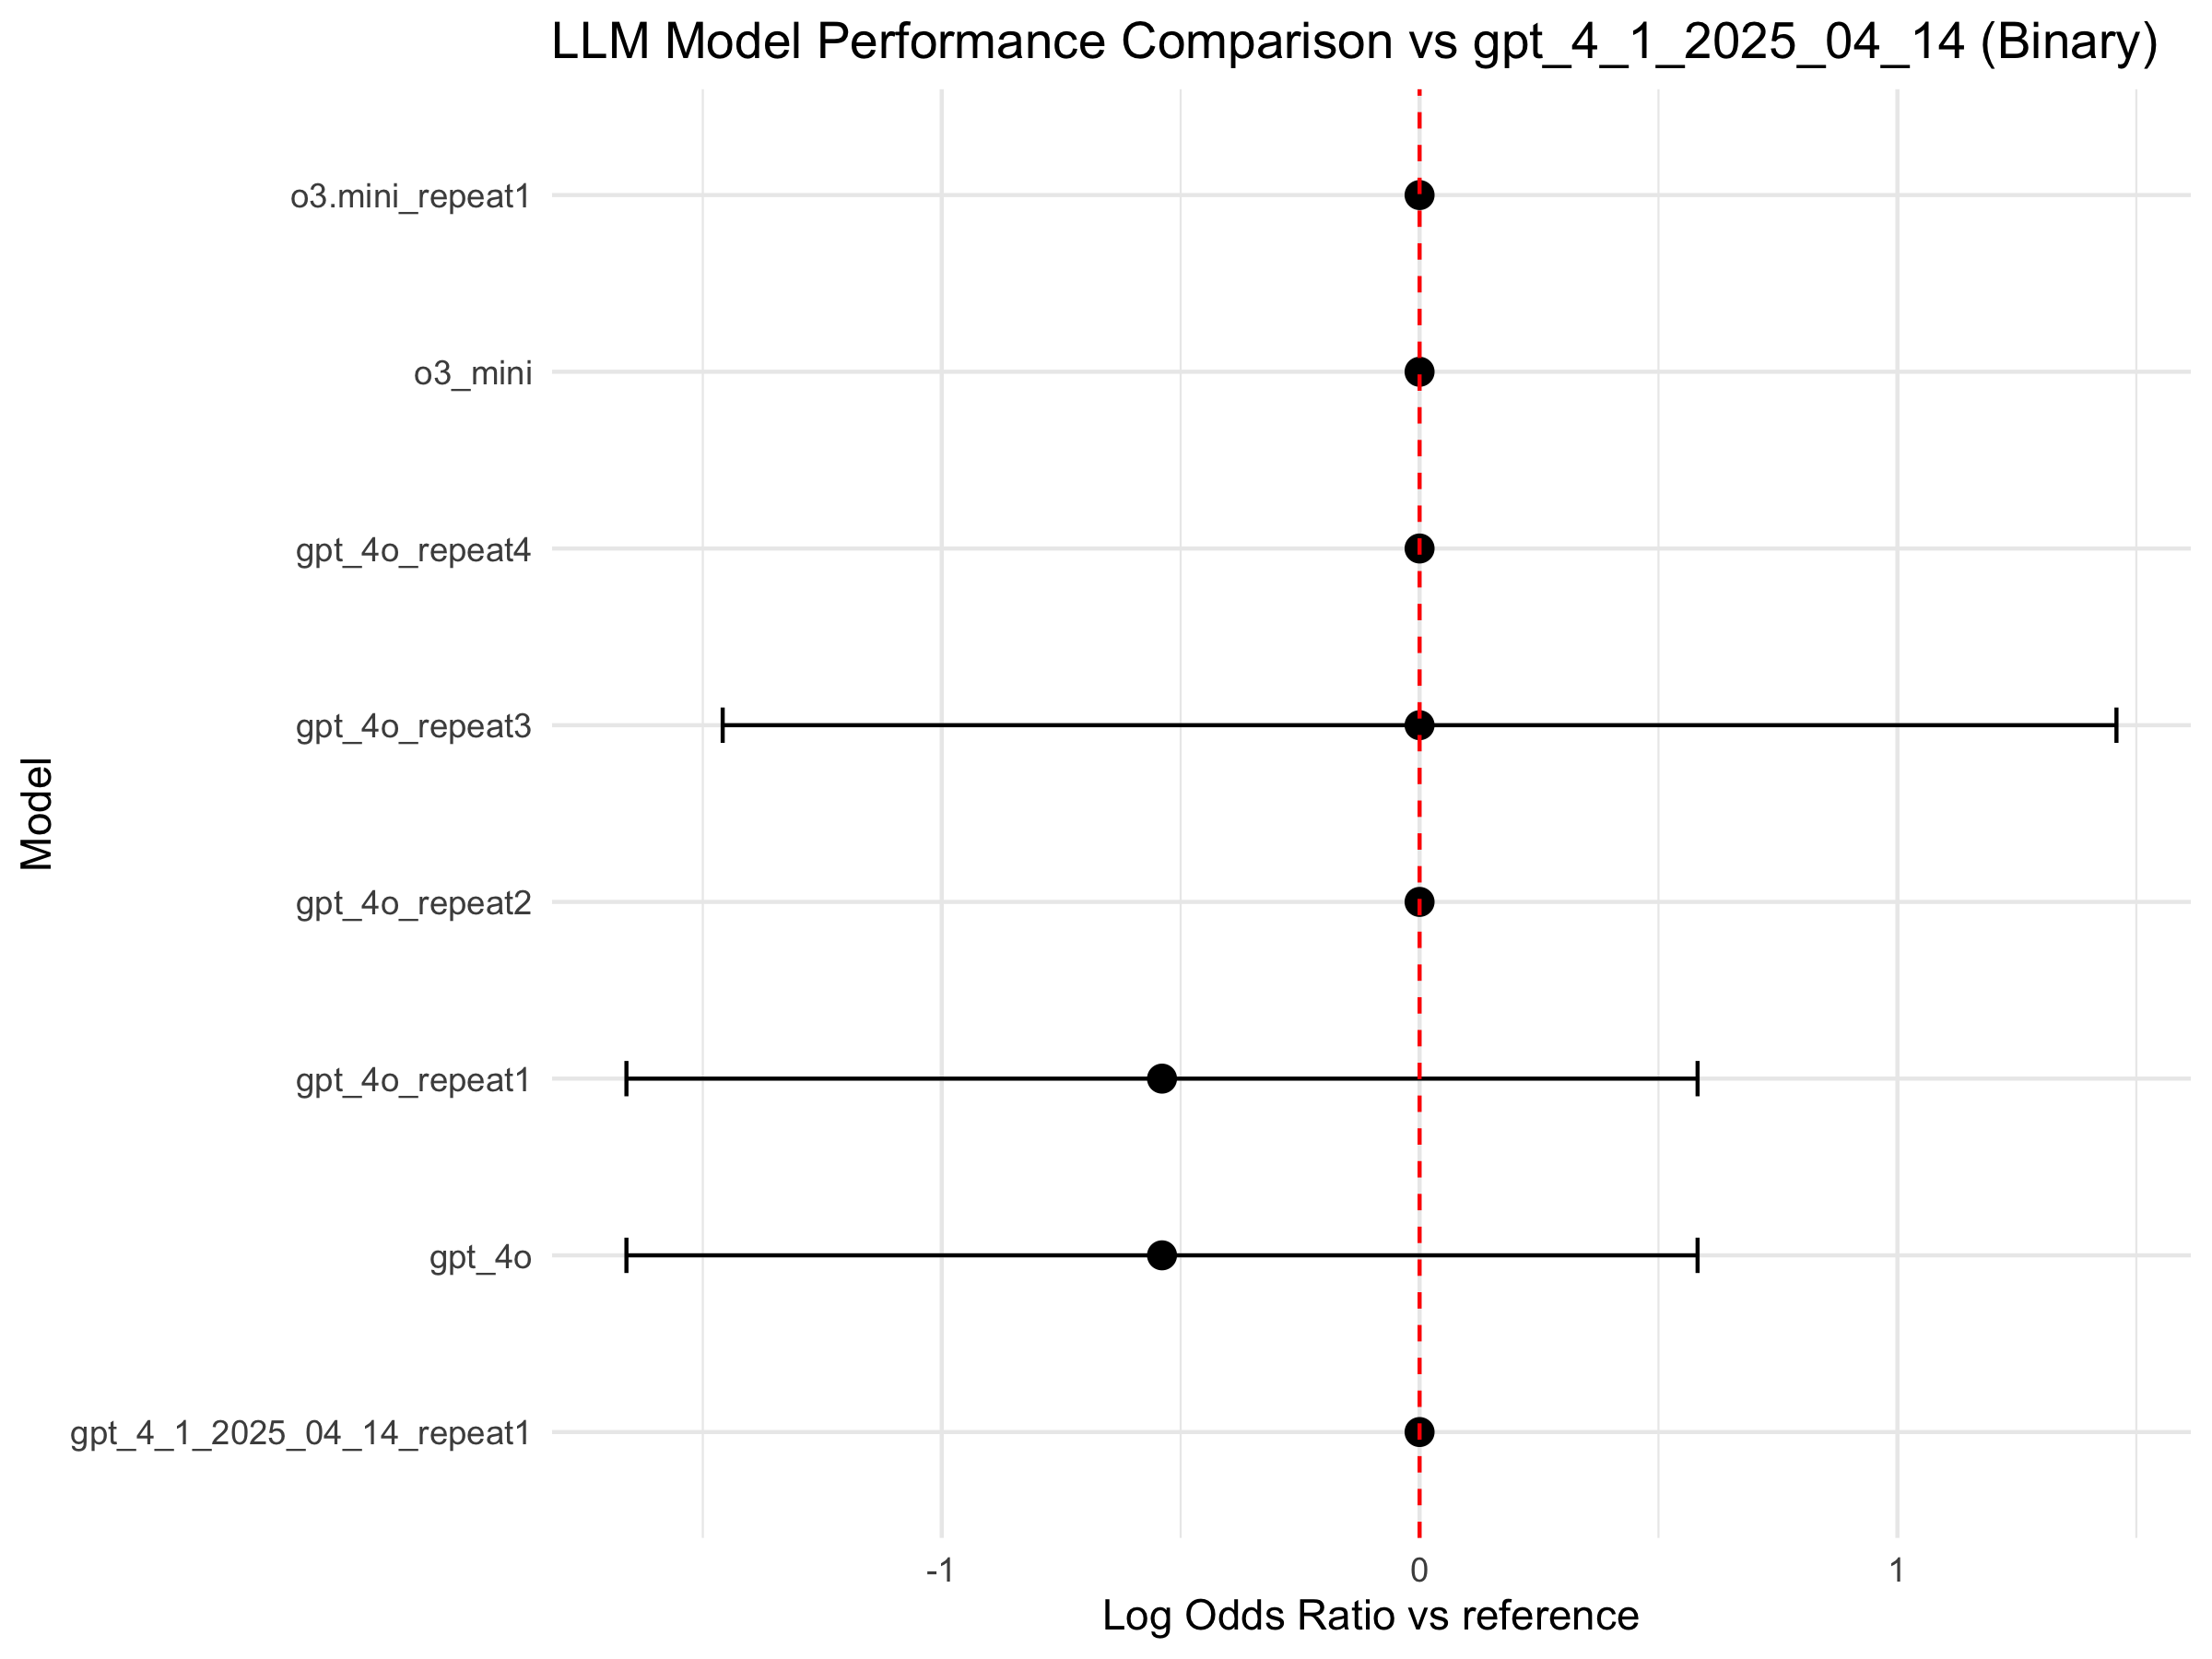

In [8]:
from scr.regression_utils import create_regression_csv

source_path = os.path.join(BASE_PATH, 'outputs/Combined_Files', 'fearspeech.csv')
output_path = os.path.join(BASE_PATH, 'outputs/Regression', 'fearspeech_regression.csv')
if os.path.exists(source_path):
    try:
        df_src = pd.read_csv(source_path)
        if ('majority_label' in df_src.columns) and df_src['majority_label'].notna().any():
            create_regression_csv(source_path, 'majority_label', output_path)
            # Run regression analysis (binary accuracy) for the generated fearspeech CSV
            try:
                script_sh = os.path.join(SCRIPT_DIR, 'scr', 'regression_analysis', 'run_model_comparison.sh')
                subprocess.run(['bash', script_sh], cwd=SCRIPT_DIR, check=True)
            except Exception as e:
                print(f"Warning: Regression analysis script failed: {e}")
        else:
            print("Warning: No ground truth in combined CSV. Skipping regression CSV generation.")
    except Exception as e:
        print(f"Warning: Failed to create regression CSV: {e}")
else:
    print("Warning: Combined fearspeech CSV not found. Skipping regression CSV generation.")

from IPython.display import Image, display
plot_path = os.path.join(SCRIPT_DIR, 'outputs', 'Plots', 'regression', 'combined_model_comparison_binary.png')
if os.path.exists(plot_path):
    display(Image(filename=plot_path))


### Section 5 — Threshold plot with FSD (sampling-based)

We generate a plot of weighted Kappa vs. an FSD threshold using `plot_kappa_vs_threshold_fearspeech_with_fsd` from `scr/threshold_plot.py`:
- **FSD (Feature Stability Distance, sampling-based here)**: Computed by `calculate_fsd` over multiple sampled outputs from the same model family (e.g., several `gpt-4o` iterations). Intuition: higher FSD means the main model is more stable/decisive on that item.
- **Gating rule**: If FSD ≥ t, use the main model’s label; else, use a majority vote over auxiliary families. We sweep t ∈ [0, 1] and compute Kappa vs. ground truth.
- The function reads `outputs/Combined_Files/fearspeech.csv`, identifies model columns by suffix, and saves a PNG into `silicon_demo/outputs/`.

This cell also writes the per-row FSD series to `outputs/fsd_per_task/fearspeech_fsd.csv` for inspection.


Saved sampling-based FSD.
FSD-gated threshold plot saved.
Kappa vs FSD threshold:


,Threshold,Kappa
0,0.0,0.137
1,0.1,0.255
2,0.2,0.255
3,0.3,0.255
4,0.4,0.255
5,0.5,0.255
6,0.6,0.255
7,0.7,0.255
8,0.8,0.255
9,0.9,0.255


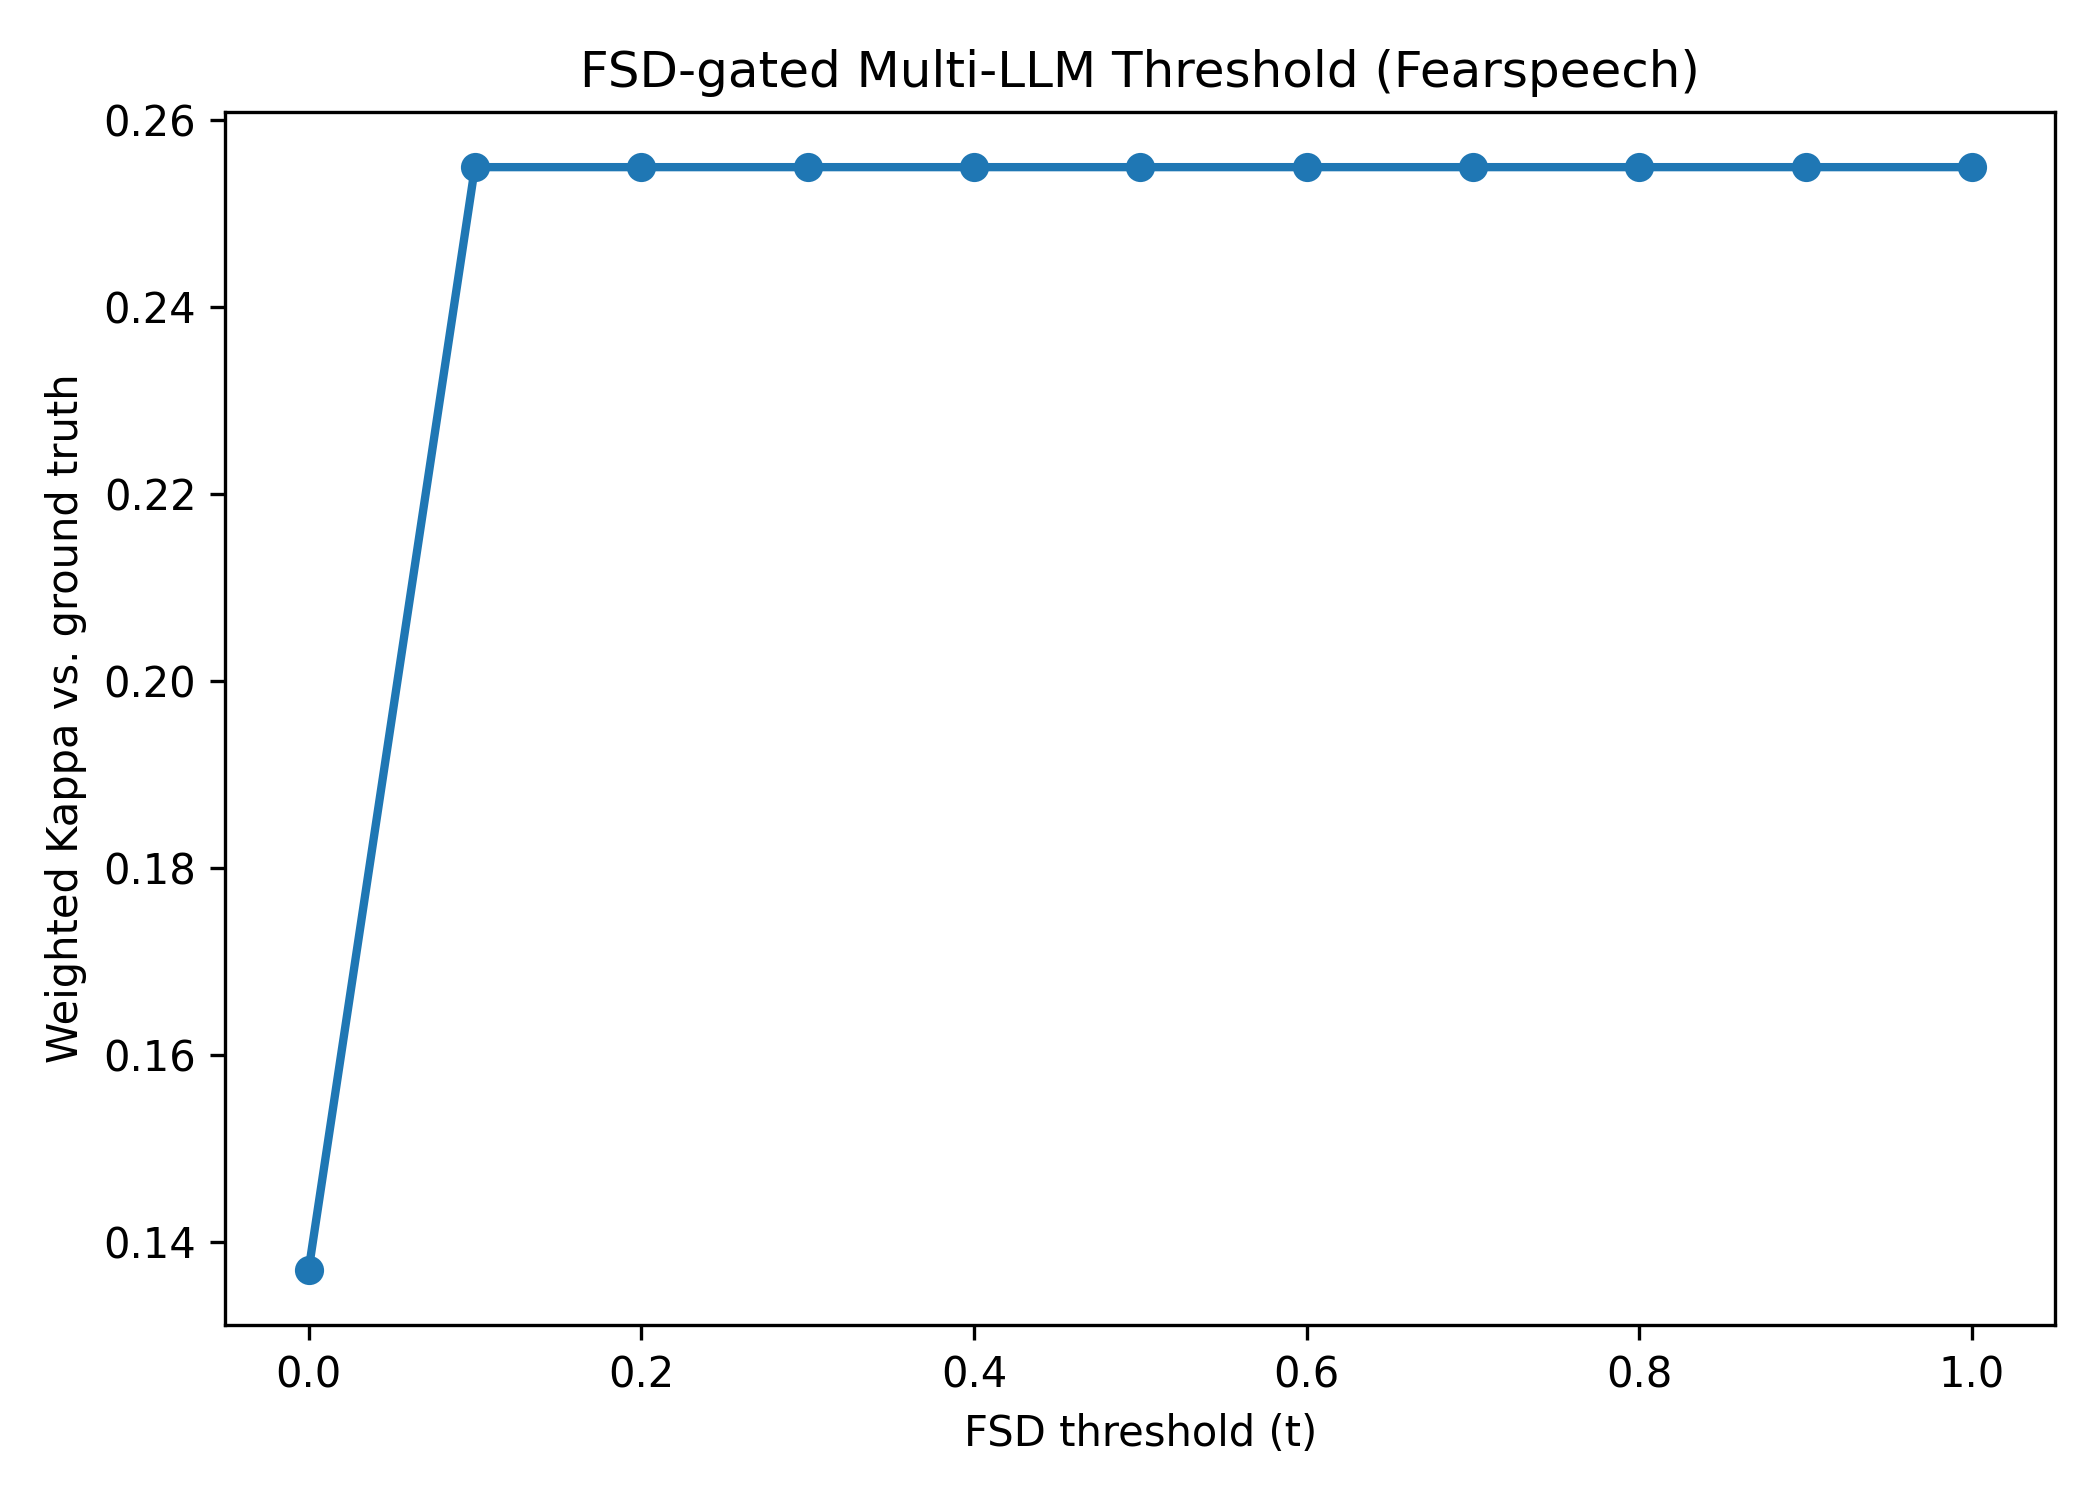

In [9]:
from scr.threshold_plot import plot_kappa_vs_threshold_fearspeech_with_fsd
from scr.fsd_sampling import calculate_fsd

plot_save_fsd = os.path.join(SCRIPT_DIR, 'outputs', 'kappa_vs_threshold_fearspeech_fsd.png')
combined_exists = os.path.exists(os.path.join(BASE_PATH, 'outputs/Combined_Files', 'fearspeech.csv'))
if combined_exists:
    try:
        df_plot_src = pd.read_csv(os.path.join(BASE_PATH, 'outputs/Combined_Files', 'fearspeech.csv'))
        has_gt_plot = ('majority_label' in df_plot_src.columns) and df_plot_src['majority_label'].notna().any()
        # Require demo label_llm* columns
        has_demo_cols = any(c.startswith('label_llm') and c != 'label_llm' for c in df_plot_src.columns)
        if has_gt_plot and has_demo_cols:
            # Step A: Generate FSD dataset for 'gpt-4o' models (sampling-based) into silicon_demo/outputs/fsd_per_task
            fsd_out_dir = os.path.join(SCRIPT_DIR, 'outputs', 'fsd_per_task')
            os.makedirs(fsd_out_dir, exist_ok=True)
            fsd_out_path = os.path.join(fsd_out_dir, 'fearspeech_fsd.csv')

            # Identify 'gpt-4o*' sampled columns from combined CSV
            def _normalize_token(s: str) -> str:
                return ''.join(ch for ch in s.lower() if ch.isalnum())

            def _match_model_cols(df_any: pd.DataFrame, family_aliases: list) -> list:
                norm_aliases = {_normalize_token(a) for a in family_aliases}
                cols = []
                for c in df_any.columns:
                    if not (c.startswith('label_llm') and c != 'label_llm'):
                        continue
                    suffix = c[len('label_llm'):].lstrip('_')
                    norm_suffix = _normalize_token(suffix)
                    if any(a in norm_suffix for a in norm_aliases):
                        cols.append(c)
                return cols

            main_cols = _match_model_cols(df_plot_src, ['gpt-4o', 'gpt_4o', 'gpt4o'])
            if len(main_cols) < 2:
                raise ValueError("Need at least two 'gpt-4o' sampled columns in Combined_Files to compute FSD.")

            df_with_scores = calculate_fsd(df_plot_src, main_cols, return_row_scores=True, row_score_col='fsd')
            fsd_df = pd.DataFrame({'fsd': df_with_scores['fsd']})
            fsd_df.to_csv(fsd_out_path, index=False)
            print(f"Saved sampling-based FSD.")

            # Step B: Run FSD-gated threshold plot
            summary_fsd = plot_kappa_vs_threshold_fearspeech_with_fsd(
                    base_path=BASE_PATH,
                    save_path=plot_save_fsd,
                    main_aliases=['gpt_4o'],
                    families_for_mv=['gpt_4_1_2025_04_14', 'o3_mini'],
                    weighted_kappa=is_multi_label_task,
            )
            print(f"FSD-gated threshold plot saved.")
            if summary_fsd is not None and not summary_fsd.empty:
                print("Kappa vs FSD threshold:")
                display(summary_fsd)
        else:
            print("Warning: Insufficient data (ground truth or model columns) for threshold plot. Skipping.")
    except Exception as e:
        print(f"Warning: Failed to generate threshold plot: {e}")
else:
    print("Warning: Combined fearspeech CSV not found. Skipping threshold plot.")

if os.path.exists(plot_save_fsd):
    display(Image(filename=plot_save_fsd))
